In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
%matplotlib inline
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./utility-vista-307720-6cec755818c9.json"
client = bigquery.Client()
%load_ext google.cloud.bigquery

In [2]:
zrimf=pd.read_csv("Zip_Zri_MultiFamilyResidenceRental.csv")

In [3]:
zrimf.rename(columns={"RegionName":"zipcode"},inplace=True)

zrimf.loc[1849,'Metro']="Boston-Cambridge-Newton"
zrimf.loc[1857,'Metro']="Las Vegas-Henderson-Paradise"
zrimf.loc[1859,'Metro']="Las Vegas-Henderson-Paradise"

phoenixmf = zrimf[zrimf.Metro.str.contains('Phoenix')]
print(phoenixmf.shape)

missingRowsMultiple = pd.isnull(phoenixmf).sum(axis=1) > 0
missingColsMultiple = pd.isnull(phoenixmf).sum(axis=0) > 0

#Dropping columns with more than 1/2 of a zipcode's data missing
for col in phoenixmf.columns[missingColsMultiple]:
    if pd.isnull(phoenixmf[col]).sum()>15:
        print(f"Dropping {col} from Multifamily")
        phoenixmf.drop(col,axis=1,inplace=True)

#Dropping zipcodes with more than 40% of index data missing
phoenixmf = phoenixmf[pd.isnull(phoenixmf).sum(axis=1)<50]
phoenixmf['zipcode'].unique()


(25, 120)
Dropping 2010-09 from Multifamily
Dropping 2010-10 from Multifamily
Dropping 2010-11 from Multifamily
Dropping 2010-12 from Multifamily
Dropping 2011-01 from Multifamily
Dropping 2011-02 from Multifamily
Dropping 2011-03 from Multifamily
Dropping 2011-04 from Multifamily
Dropping 2011-05 from Multifamily
Dropping 2011-06 from Multifamily
Dropping 2011-07 from Multifamily
Dropping 2011-08 from Multifamily
Dropping 2011-09 from Multifamily
Dropping 2011-10 from Multifamily
Dropping 2011-11 from Multifamily
Dropping 2011-12 from Multifamily
Dropping 2012-01 from Multifamily
Dropping 2012-02 from Multifamily
Dropping 2012-03 from Multifamily
Dropping 2012-04 from Multifamily
Dropping 2012-05 from Multifamily
Dropping 2012-06 from Multifamily
Dropping 2012-07 from Multifamily
Dropping 2012-08 from Multifamily
Dropping 2012-09 from Multifamily
Dropping 2012-10 from Multifamily
Dropping 2012-11 from Multifamily
Dropping 2012-12 from Multifamily
Dropping 2013-01 from Multifamily
Drop

/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([85032, 85281, 85251, 85282, 85204, 85008, 85201, 85016, 85224,
       85283, 85018, 85260, 85044, 85020, 85027, 85015, 85014])

In [4]:
missingRowsMultiplePost = pd.isnull(phoenixmf).sum(axis=1) > 0
missingColsMultiplePost = pd.isnull(phoenixmf).sum(axis=0) > 0
print(phoenixmf.columns[missingColsMultiplePost])
#impute with min -- another option is to fillna(method=ffill)
phoenixmf=phoenixmf.apply(lambda row: row.fillna(row[7:].min()), axis=1)
print(phoenixmf.shape)

Index(['2014-02', '2016-01', '2016-02', '2016-03', '2016-05', '2016-07',
       '2019-01', '2019-02', '2019-03', '2019-10', '2019-11', '2019-12',
       '2020-01'],
      dtype='object')
(17, 79)


In [6]:
#print((pd.isnull(phoenixmf_long).sum(axis=1) > 0).sum())
#print((pd.isnull(phoenixmf_long).sum(axis=0) > 0).sum())

In [7]:
valueCols=[col for col in phoenixmf.columns if '20' in col] #columns with the indices
indexCols=[col for col in phoenixmf.columns if '20' not in col] #columns without the indices
phoenixmf_long=pd.melt(phoenixmf, id_vars=indexCols, value_vars=valueCols, var_name="Period",value_name="ZRI")

<AxesSubplot:ylabel='Frequency'>

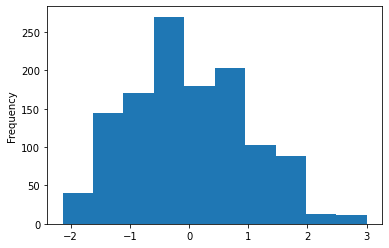

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
phoenixmf_long["ZRI_norm"]=scaler.fit_transform(phoenixmf_long[["ZRI"]]).flatten()
phoenixmf_long["ZRI_norm"].plot.hist()

In [9]:
phoenixmf_long.loc[:,"Year"]=phoenixmf_long["Period"].apply(lambda x: x.split("-")[0])
phoenixmf_long.loc[:,"Month"]=phoenixmf_long["Period"].apply(lambda x: x.split("-")[1])

In [10]:
phoenixmf_long.to_csv("Phoenix_MF_ZRI.csv")

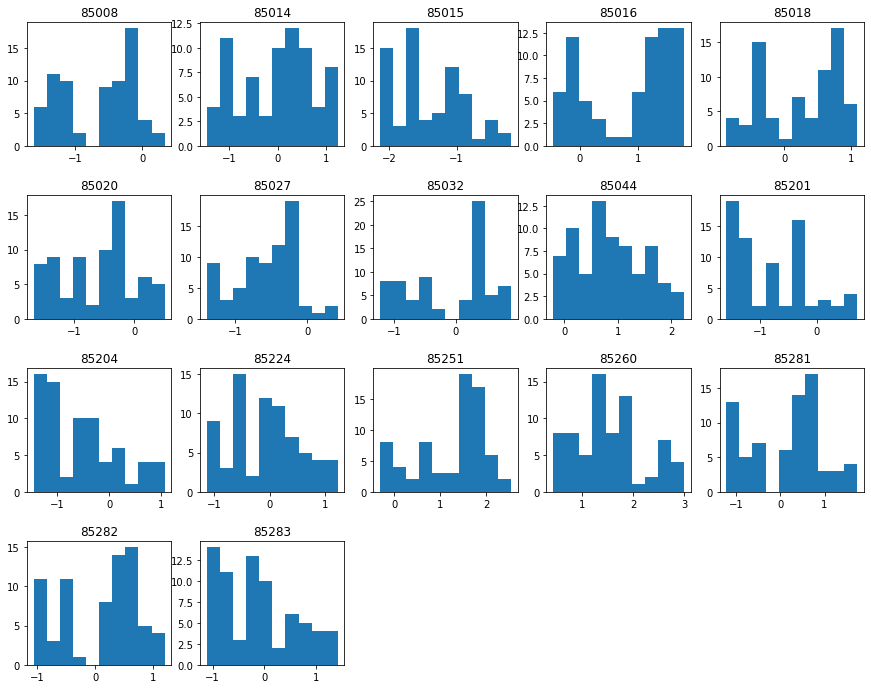

In [11]:
phoenixmf_zipcode=phoenixmf_long.groupby(["zipcode"])
plt.figure(figsize=(15,15))  # change the size of figure!
i=0
for zipcode,frame in phoenixmf_zipcode:
    plt.subplot(5, 5, i+1)
    plt.hist(frame["ZRI_norm"])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(zipcode)  
    i+=1
plt.show()

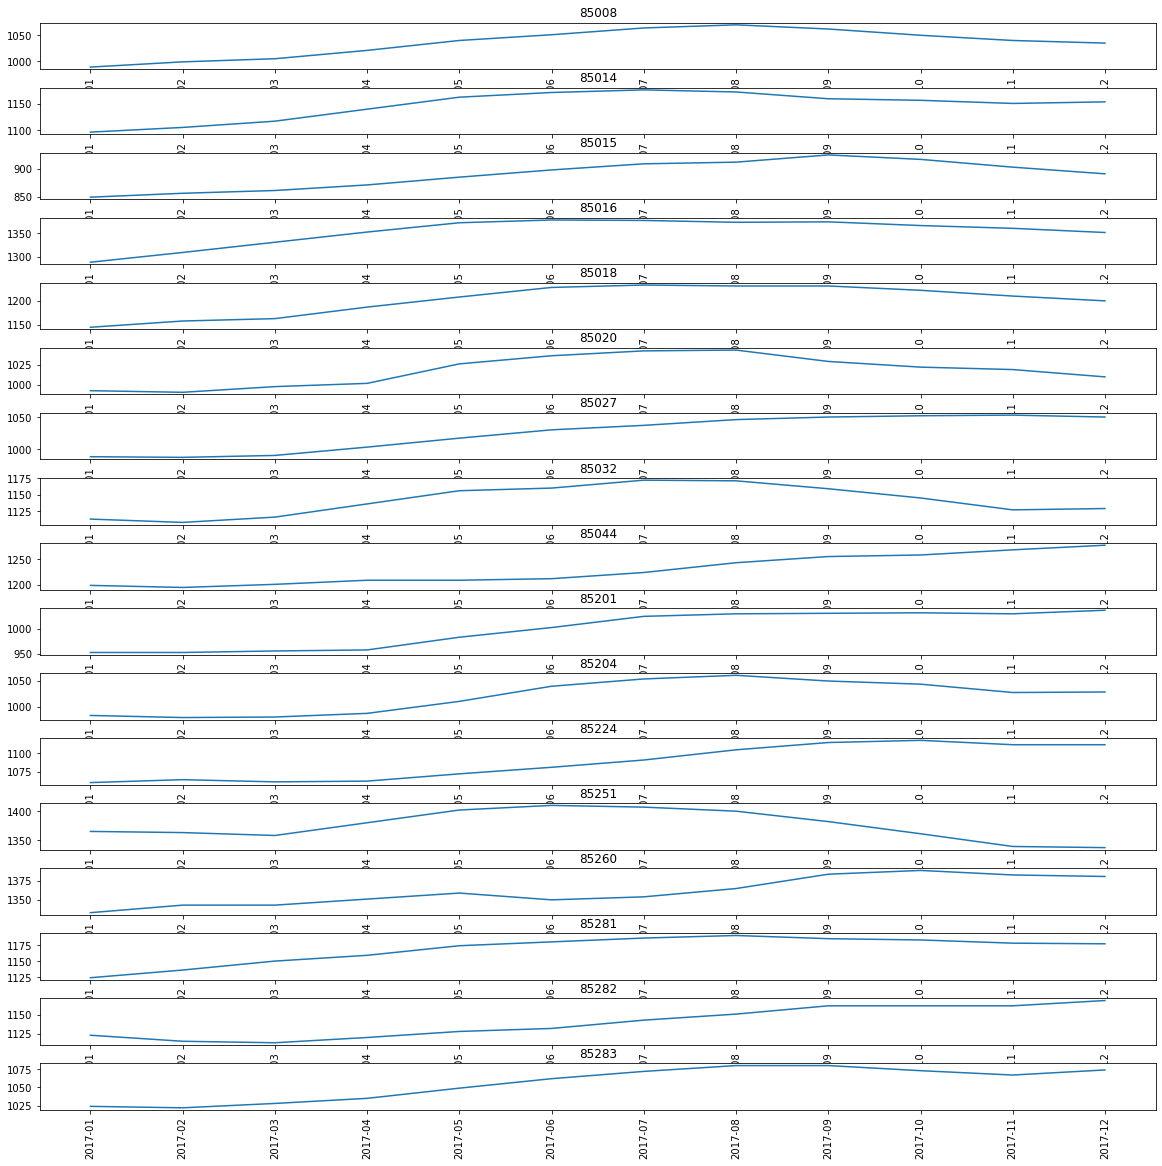

In [12]:
phoenixmf_zipcode=phoenixmf_long.groupby(["zipcode"])
plt.figure(figsize=(20,20))  # change the size of figure!
i=0
startYear=2017
for zipcode,frame in phoenixmf_zipcode:
    newFrame=frame[frame["Period"].str.contains(str(startYear))]
    plt.subplot(17, 1, i+1)
    plt.plot(newFrame["Period"],newFrame["ZRI"])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(zipcode)  # Plot title here!!!
    plt.xticks(rotation=90)
    i+=1
plt.show()